In [1]:
# This python notebook is used to build a text classifier for language complexity 
# This model is built on three languages - English, Hindi and Telugu
# This script uses the CBOW model for Hindi and Telugu languages from the corpus provided by CivicDataLabs
# The output of this script is a text classifier for Hindi and Telugu trained on the provided corpus 
# Author - Karthik D

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import hiddenlayer as hl
from nltk.corpus import wordnet
import nltk

In [2]:
from pathlib import Path
import unidecode
import unicodedata
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm_notebook,tqdm
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,DataLoader,TensorDataset
from torch.autograd import Variable
from torch import optim
import time
import pdb
import gc
import re

Using TensorFlow backend.


# **Device Definition**

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# **Prepare Train-Test Data**

In [4]:
train_df = df = pd.read_csv("data_stories.csv")
train_df = train_df[["content", 'reading_level_updated', 'story_langugage']]
print(len(train_df))
train_df = train_df.drop(train_df.index[[3658, 3669, 3686]])
train_df = train_df.dropna()
print(len(train_df))

3697
3637


In [5]:
eng_df = train_df[train_df.story_langugage == 'English']
hin_df = train_df[train_df.story_langugage == 'Hindi']
tel_df = train_df[train_df.story_langugage == 'Telugu']

hin_df.content = hin_df.content.str.replace(r'[A-Za-z0-9&;:!,\-.()?”“\'\'\"\\]', "")
tel_df.content = tel_df.content.str.replace(r'[A-Za-z0-9&;!:,\-.()?”“\'\'\"\\]', "")
eng_df.content = eng_df.content.str.replace(r'[0-9&;!:\-,.()?”“\'\'\"\\]', "")

hin_df.content = hin_df.content.str.replace(r"[\n]","")
hin_df.content = hin_df.content.str.replace(r"[\t]","")
hin_df.content = hin_df.content.str.replace(r"[\r]","")
hin_df.content = hin_df.content.str.replace(r"[\\u]","")

tel_df.content = tel_df.content.str.replace(r"[\n]","")
tel_df.content = tel_df.content.str.replace(r"[\t]","")
tel_df.content = tel_df.content.str.replace(r"[\r]","")
tel_df.content = tel_df.content.str.replace(r"[\\u]","")

eng_df.content = eng_df.content.str.replace(r"[\n]","")
eng_df.content = eng_df.content.str.replace(r"[\t]","")
eng_df.content = eng_df.content.str.replace(r"[\r]","")
eng_df.content = eng_df.content.str.replace(r"[\\u]","")

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [6]:
def train_test_split(df, perc):
    msk = np.random.rand(len(df)) < perc
    train = df[msk]
    test = df[~msk]
    return train, test

eng_train, eng_test = train_test_split(eng_df, 0.95)
tel_train, tel_test = train_test_split(tel_df, 0.8)
hin_train, hin_test = train_test_split(hin_df, 0.8)

In [7]:
def seed_everything(seed=4823):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [8]:
em_sz = 300
vocab_sz = 70000
max_len=250

In [9]:
def lang_tokenizer(df):
    tokenizer = Tokenizer(vocab_sz)
    tokenizer.fit_on_texts(df.content)
    return tokenizer

hin_train_tokenizer = lang_tokenizer(hin_train)
eng_train_tokenizer = lang_tokenizer(eng_train)
tel_train_tokenizer = lang_tokenizer(tel_train)

hin_test_tokenizer = lang_tokenizer(hin_test)
eng_test_tokenizer = lang_tokenizer(eng_test)
tel_test_tokenizer = lang_tokenizer(tel_test)

In [10]:

def lang_tokenizer2(tokenizer, df):
    x_dev = tokenizer.texts_to_sequences(df.content.values)
    tokenizer.word_index.update({"<eof>":len(tokenizer.word_index)+1})
    print(len(tokenizer.word_index))
    return x_dev, tokenizer

hin_x_train, hin_train_tokenizer = lang_tokenizer2(hin_train_tokenizer, hin_train)
eng_x_train, eng_train_tokenizer = lang_tokenizer2(eng_train_tokenizer, eng_train)
tel_x_train, tel_train_tokenizer = lang_tokenizer2(tel_train_tokenizer, tel_train)

hin_x_test, hin_test_tokenizer = lang_tokenizer2(hin_test_tokenizer, hin_test)
eng_x_test, eng_test_tokenizer = lang_tokenizer2(eng_test_tokenizer, eng_test)
tel_x_test, tel_test_tokenizer = lang_tokenizer2(tel_test_tokenizer, tel_test)

40671
66891
34371
12370
5956
11547


In [11]:
hin_x_train = pad_sequences(hin_x_train, maxlen=max_len)
eng_x_train = pad_sequences(eng_x_train, maxlen=max_len)
tel_x_train = pad_sequences(tel_x_train, maxlen=max_len)

hin_x_test = pad_sequences(hin_x_test, maxlen=max_len)
eng_x_test = pad_sequences(eng_x_test, maxlen=max_len)
tel_x_test = pad_sequences(tel_x_test, maxlen=max_len)

In [12]:
hin_y_train = hin_train.reading_level_updated.values
hin_y_train = [int(s.replace('L' , ''))-1 for s in hin_y_train]
hin_y_test = hin_test.reading_level_updated.values
hin_y_test = [int(s.replace('L' , ''))-1 for s in hin_y_test]

eng_y_train = eng_train.reading_level_updated.values
eng_y_train = [int(s.replace('L' , ''))-1 for s in eng_y_train]
eng_y_test = eng_test.reading_level_updated.values
eng_y_test = [int(s.replace('L' , ''))-1 for s in eng_y_test]

tel_y_train = tel_train.reading_level_updated.values
tel_y_train = [int(s.replace('L' , '')) -1 for s in tel_y_train]
tel_y_test = tel_test.reading_level_updated.values
tel_y_test = [int(s.replace('L' , '')) -1 for s in tel_y_test]

print(np.unique(hin_y_train))
print(np.unique(hin_y_test))
print(np.unique(tel_y_train))
print(np.unique(tel_y_test))
print(np.unique(eng_y_train))
print(np.unique(eng_y_test))

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]


# **Embedding Loader Functions**

In [13]:
EMB_PATH = ('glove.6B.300d.txt')
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')


def load_glove(word_index):
    EMBEDDING_FILE = EMB_PATH
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(vocab_sz, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= vocab_sz: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i:] = embedding_vector        
    return embedding_matrix 

def build_hindi_embedding(word_index):
    hin_vocab_size = 44870
    all_embs = np.array([hin_emb.get_word_vector(i).cpu().detach().numpy() for i in range(0, hin_vocab_size)])
    all_embs = all_embs.reshape(all_embs.shape[0], all_embs.shape[2])
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(hin_vocab_size, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= hin_vocab_size: continue
        embedding_vector = hin_emb.get_word_vector(i).cpu().detach().numpy()
        if embedding_vector is not None: embedding_matrix[i:] = embedding_vector        
    return embedding_matrix 

def build_telugu_embedding(word_index):
    tel_vocab_size = 41261
    all_embs = np.array([tel_emb.get_word_vector(i).cpu().detach().numpy() for i in range(0, tel_vocab_size)])
    all_embs = all_embs.reshape(all_embs.shape[0], all_embs.shape[2])
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(tel_vocab_size, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= tel_vocab_size: continue
        embedding_vector = tel_emb.get_word_vector(i).cpu().detach().numpy()
        if embedding_vector is not None: embedding_matrix[i:] = embedding_vector        
    return embedding_matrix 

# **Embedding Class Definition**

In [14]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size, context_size):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.context_size = context_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        # return vector size will be context_size*2*embedding_size
        self.lin1 = nn.Linear(self.context_size * 2 * self.embedding_size, 512)
        self.lin2 = nn.Linear(512, self.vocab_size)
    
    def forward(self, inp):
        out = self.embeddings(inp).view(1, -1)
        out = out.view(1, -1)
        out = self.lin1(out)
        out = F.relu(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def get_word_vector(self, word_idx):
        word = Variable(torch.LongTensor([word_idx])).to(device)
        return self.embeddings(word).view(1, -1)

# **Load Embeddings files**

In [15]:
import pickle

with open('hin_emb.pkl', 'rb') as f:
    hin_emb = pickle.load(f)
    
with open('tel_emb.pkl', 'rb',) as f:
    tel_emb = pickle.load(f)
    
print(tel_emb)
print(hin_emb)

CBOW(
  (embeddings): Embedding(41261, 300)
  (lin1): Linear(in_features=2400, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=41261, bias=True)
)
CBOW(
  (embeddings): Embedding(44870, 300)
  (lin1): Linear(in_features=2400, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=44870, bias=True)
)


# **Create Embeddings from files**

In [16]:
seed_everything()
hin_embed_train = None
hin_embed_test = None
em_fns = [build_hindi_embedding]
hin_embed_train = np.concatenate([fn(hin_train_tokenizer.word_index) for fn in em_fns],1)
hin_embed_test = np.concatenate([fn(hin_test_tokenizer.word_index) for fn in em_fns],1)
gc.collect()
print(hin_embed_train.shape)
print(hin_embed_test.shape)

(40671, 300)
(12370, 300)


In [17]:
seed_everything()
tel_embed_train = None
tel_embed_test = None
em_fns = [build_telugu_embedding]
tel_embed_train = np.concatenate([fn(tel_train_tokenizer.word_index) for fn in em_fns],1)
tel_embed_test = np.concatenate([fn(tel_test_tokenizer.word_index) for fn in em_fns],1)
gc.collect()
print(tel_embed_train.shape)
print(tel_embed_test.shape)

(34371, 300)
(11547, 300)


In [18]:
seed_everything()
eng_embed_train = None
eng_embed_test = None
em_fns = [load_glove]
eng_embed_train = np.concatenate([fn(eng_train_tokenizer.word_index) for fn in em_fns],1)
eng_embed_test = np.concatenate([fn(eng_test_tokenizer.word_index) for fn in em_fns],1)
gc.collect()
print(eng_embed_train.shape)
print(eng_embed_test.shape)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


(66891, 300)
(5956, 300)


# **Define Model Architecture**

In [19]:
def sigmoid(x):return 1 / (1 + np.exp(-x))
class TextClassifierSimpleLSTM(nn.Module):
    def __init__(self,vocab_sz,emb_sz,hn=40):
        super().__init__()
        self.hn,self.vocab_sz,self.emb_sz = hn,vocab_sz,emb_sz
        self.emb = nn.Embedding(vocab_sz,emb_sz)
        self.emb.weight = nn.Parameter(torch.tensor(embed,dtype=torch.float32))
        self.emb.weight.requires_grad = False
        self.e_d = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(emb_sz, hn, bidirectional=True, batch_first=True)
        self.lstm_atn = Attention(hn * 2, max_len)
        self.fc = nn.Sequential(nn.Linear(240,16),nn.ReLU(),nn.Dropout(0.1),
                                nn.Linear(16,1))

    def forward(self,x):
        e_o = torch.squeeze(self.e_d(torch.unsqueeze(self.emb(x),0)))
        lstm_o,_ = self.lstm(e_o)
        lstm_atn = self.lstm_atn(lstm_o)
        concat_o = torch.cat([lstm_atn,torch.mean(lstm_o,1),torch.max(lstm_o,1)[0]],1)
        return self.fc(concat_o)
    
class TextClassifier(nn.Module):
    def __init__(self, embed, vocab_sz, emb_sz, hn=60):
        super().__init__()
        self.hn, self.vocab_sz, self.emb_sz = hn,vocab_sz, emb_sz
        self.emb = nn.Embedding(vocab_sz, emb_sz)
        self.emb.weight = nn.Parameter(torch.tensor(embed, dtype=torch.float32))
        self.emb.weight.requires_grad = False
        self.e_d = nn.Dropout2d(0.3)
        self.lstm = nn.LSTM(emb_sz, hn, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hn*2, hn, batch_first=True, bidirectional=True)
        #self.lstm_atn = Attention(hn * 2, max_len)
        #self.gru_atn = Attention(hn * 2, max_len)
        self.fc = nn.Sequential(nn.Linear(hn*4, 16),nn.ReLU(),nn.Dropout(0.1),
                                nn.Linear(16, num_classes))

    def forward(self,x):
        #print("x:", x.shape)
        e_o = torch.squeeze(self.e_d(torch.unsqueeze(self.emb(x), 0)))
        #print("e_o:", e_o.shape)
        lstm_o,_ = self.lstm(e_o)
        #print("lstm_o:", lstm_o.shape)
        gru_o,_ = self.gru(lstm_o)
        #print("gru_o:", gru_o.shape)
        #lstm_atn = self.lstm_atn(lstm_o)
        #gru_atn = self.gru_atn(gru_o)
        concat_o = torch.cat([torch.mean(gru_o, 1),torch.max(gru_o, 1)[0]],1)
        #print("concat_o:", concat_o.shape)
        
        fc_out = self.fc(concat_o)
        #print("out:", fc_out.shape)
        return fc_out     

# **Utility Functions Definition**

In [20]:
def onehot_encoder(batch_size, labels):
    onehot_encoded = np.zeros(shape=(batch_size, num_classes), dtype=np.int32)
    batch=0
    for label in labels:
        onehot_encoded[batch, label] = 1
        batch+=1
    return(onehot_encoded)

def save_model(model, pth):
    torch.save(model.state_dict(),pth)
    
def get_dl_split(split_id=0):
    trn_idxs,val_idxs = splits[split_id]
    trn_ds = TensorDataset(torch.tensor(x_dev[trn_idxs], dtype=torch.long), torch.tensor(y_dev[trn_idxs, np.newaxis], dtype=torch.float32))
    val_ds = TensorDataset(torch.tensor(x_dev[val_idxs], dtype=torch.long), torch.tensor(y_dev[val_idxs, np.newaxis], dtype=torch.float32))
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=bs*6, shuffle=False)
    return trn_dl, val_dl, y_dev[val_idxs], val_idxs

def train_model(dev_dl, embed):
    
    # Instantiate model
    model = TextClassifier(embed, vocab_sz, embed.shape[1])
    model = model.to(device)
    # define loss function
    criterion = nn.CrossEntropyLoss()
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # A History object to store metrics
    history = hl.History()
    # A Canvas object to draw the metrics
    canvas = hl.Canvas()
    # Begin Training
    correct = total = step = sum_loss = 0
    print("step_size:", len(dev_dl))
    for epoch in range(num_epochs):
        for text, label in dev_dl:
            text = text.to(device)
            label = label.squeeze().to(device, dtype=torch.int64)
            step += 1
            
            output = model(text)            
            loss = criterion(output, label)
        
            optimizer.zero_grad()
            # backprop
            loss.backward()
            optimizer.step()
            
            _, predictions = torch.max(output.data, 1)
            correct += (predictions == label).sum(0).item()
            total += label.size(0)
            TrainAccuracy = correct / total
            sum_loss += loss
            avg_loss = sum_loss/step
            
            if(step % 5 == 0):
                history.log(step, loss=avg_loss, accuracy=TrainAccuracy)
                # Plot the two metrics in one graph
                canvas.draw_plot([history['loss'], history['accuracy']])
        
            print ('Epoch [{}/{}], Step [{}], Train_Loss: {:.4f}, TrainAccuracy: {:.4f}'.format(epoch+1, num_epochs, step, loss.item(), TrainAccuracy))
    return model

In [21]:
# Model hyperparameters
bs= 512 
num_epochs = 400
learning_rate = 0.001
num_classes = 4

# **Create Dataloaders**

In [22]:
eng_ds_train = TensorDataset(torch.tensor(eng_x_train, dtype=torch.long), torch.tensor(eng_y_train, dtype=torch.float32))
eng_dl_train = DataLoader(eng_ds_train, batch_size=bs, shuffle=True)

eng_ds_test = TensorDataset(torch.tensor(eng_x_test, dtype=torch.long), torch.tensor(eng_y_test, dtype=torch.float32))
eng_dl_test = DataLoader(eng_ds_test, batch_size=bs, shuffle=True)

hin_ds_train = TensorDataset(torch.tensor(hin_x_train, dtype=torch.long), torch.tensor(hin_y_train, dtype=torch.float32))
hin_dl_train = DataLoader(hin_ds_train, batch_size=bs, shuffle=True)

hin_ds_test = TensorDataset(torch.tensor(hin_x_test, dtype=torch.long), torch.tensor(hin_y_test, dtype=torch.float32))
hin_dl_test = DataLoader(hin_ds_test, batch_size=bs, shuffle=True)

tel_ds_train = TensorDataset(torch.tensor(tel_x_train, dtype=torch.long), torch.tensor(tel_y_train, dtype=torch.float32))
tel_dl_train = DataLoader(tel_ds_train, batch_size=bs, shuffle=True)

tel_ds_test = TensorDataset(torch.tensor(tel_x_test, dtype=torch.long), torch.tensor(tel_y_test, dtype=torch.float32))
tel_dl_test = DataLoader(tel_ds_test, batch_size=bs, shuffle=True)

# **Train Telugu Model**

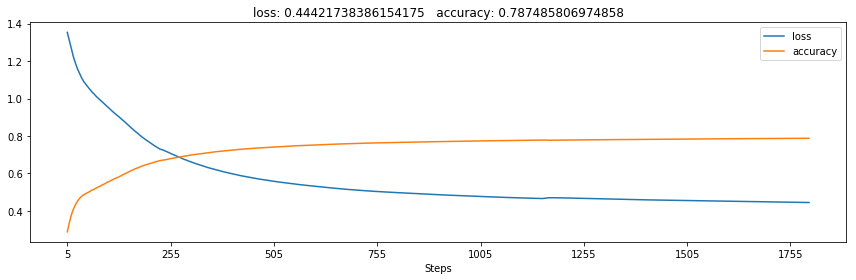

Epoch [1800/1800], Step [1800], Train_Loss: 0.4504, TrainAccuracy: 0.7875


In [23]:
# Model hyperparameters
bs= 512 
num_epochs = 1800
learning_rate = 0.001
num_classes = 4

tel_model = train_model(tel_dl_train, tel_embed_train)
save_model(tel_model, "tel_model.ckpt")

# **Train English Model**

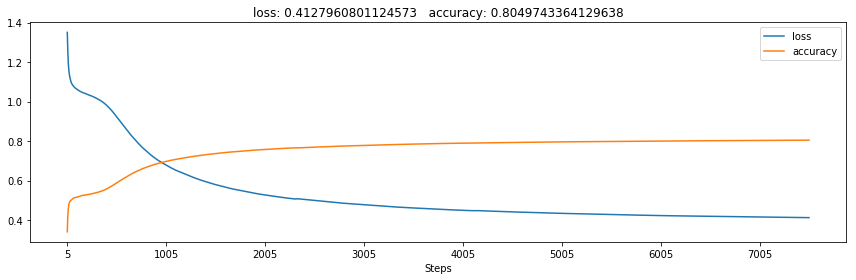

Epoch [1500/1500], Step [7500], Train_Loss: 0.2791, TrainAccuracy: 0.8050


In [24]:
# Model hyperparameters
bs= 512 
num_epochs = 1500
learning_rate = 0.001
num_classes = 4

eng_model = train_model(eng_dl_train, eng_embed_train)
save_model(eng_model, "eng_model.ckpt")

# **Train Hindi Model**

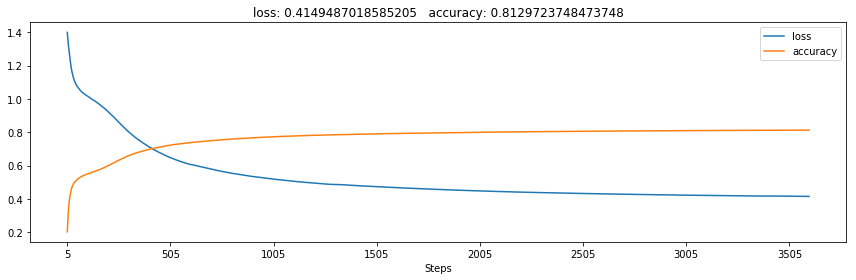

Epoch [1800/1800], Step [3600], Train_Loss: 0.3890, TrainAccuracy: 0.8130


In [25]:
# Model hyperparameters
bs= 512 
num_epochs = 1800
learning_rate = 0.001
num_classes = 4

hin_model = train_model(hin_dl_train, hin_embed_train)
save_model(hin_model, "hin_model.ckpt")

# **Inferencing**

In [29]:
# Inferencing
def inference(dl, model):
    correct = total = 0
    for text, label in dl:
        text = text.to(device)
        label = label.squeeze().to(device, dtype=torch.int64)
        output = model(text)
        _, prediction = torch.max(output.data, 1)
        correct += (prediction == label).sum(0).item()
        total += label.size(0)
        testAccuracy = correct / total
    return testAccuracy

In [30]:
Eng_accuracy = inference(eng_dl_test, eng_model)
print(Eng_accuracy)
Tel_accuracy = inference(tel_dl_test, tel_model)
print(Tel_accuracy)
Hin_accuracy = inference(hin_dl_test, hin_model)
print(Hin_accuracy)

0.5083333333333333
0.43478260869565216
0.5317919075144508
